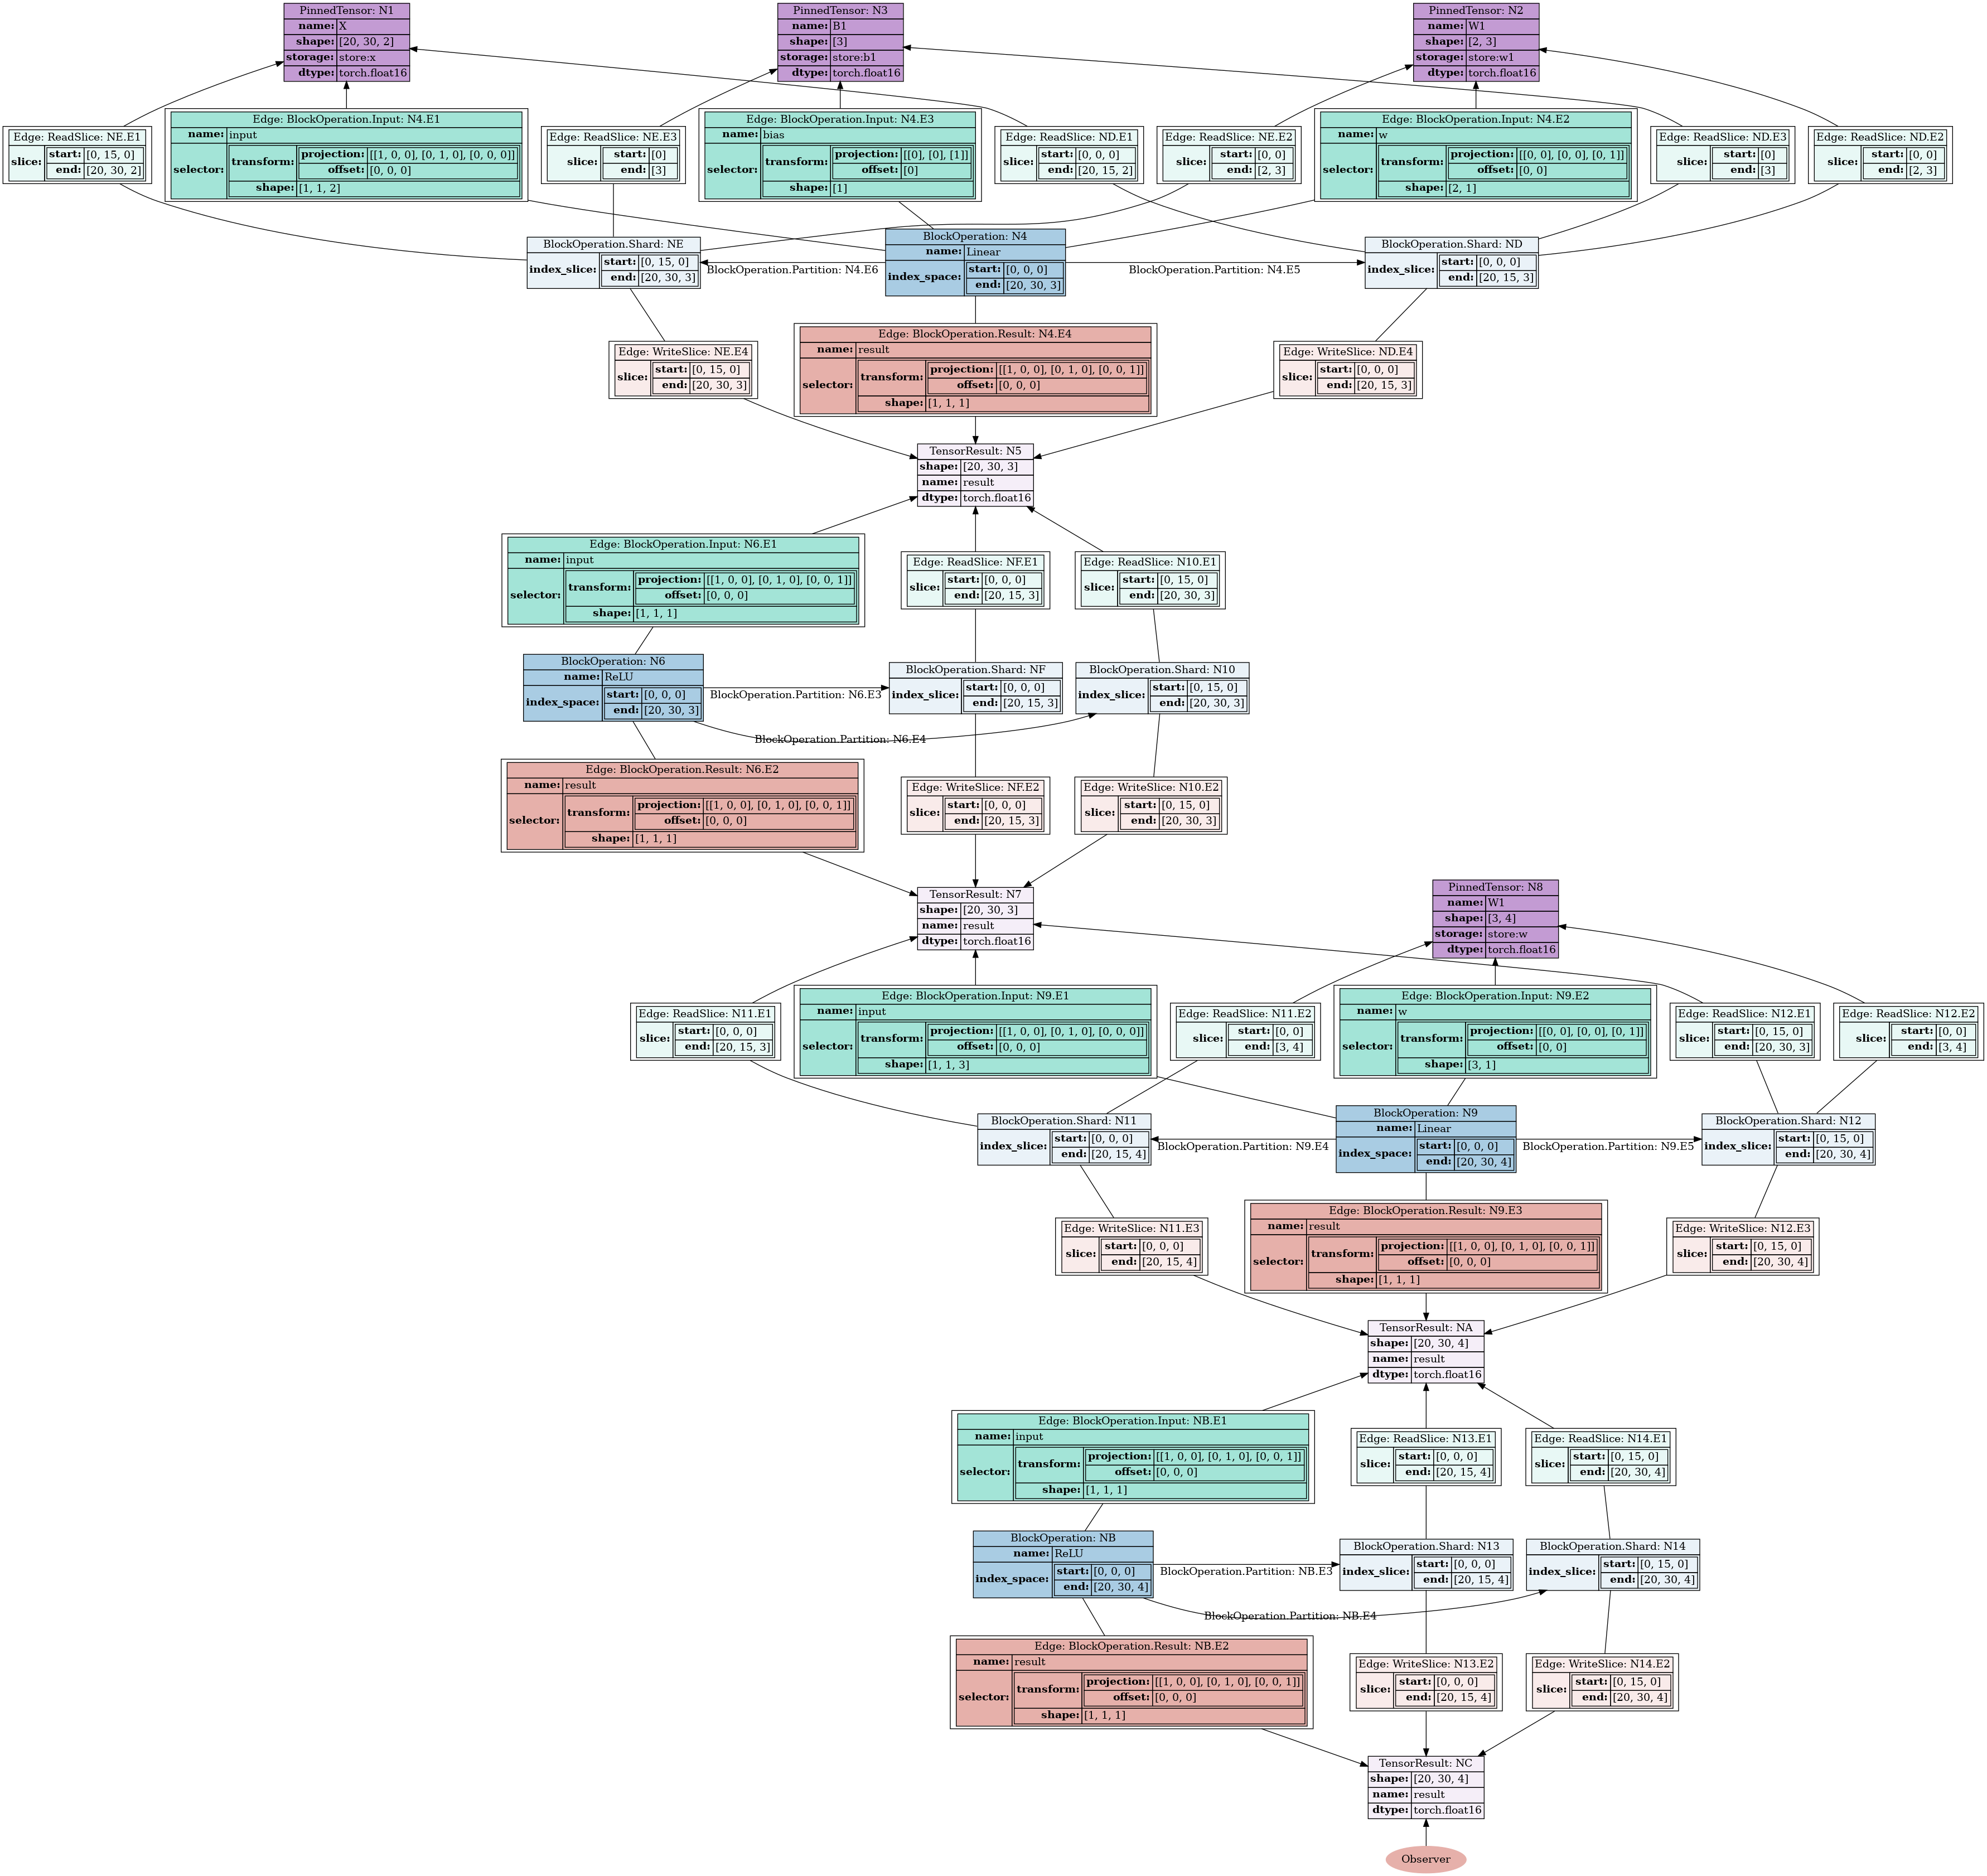

In [1]:
from tapestry.jupyter_utils import display_graph
from typing import Optional

import numpy as np
import torch

from tapestry.expression_graph import (
    BlockOperation,
    PinnedTensor,
    TapestryGraph,
    TensorResult,
    TensorValue,
)
from tapestry.zspace import EmbeddingMode, ZRange, ZRangeMap, ZTransform, assert_shape


def linear_op(
        *,
        x: TensorValue,
        w: TensorValue,
        bias: Optional[TensorValue] = None,
) -> TensorResult:
    graph = x.assert_graph()
    assert w.graph == graph

    assert len(w.shape) == 2, w.shape
    in_dim = w.shape[0]
    out_dim = w.shape[1]

    assert_shape(
        x.shape[-1:],
        w.shape[:1],
        "input shape {xshape} in_dim {actual} incompatible "
        "with weight shape {wshape} in_dim {expected}",
        xshape=x.shape,
        wshape=w.shape,
    )

    index_space = ZRange(x.shape[:-1].tolist() + [out_dim])

    op_name = "Linear"

    op = graph.add_node(
        BlockOperation(
            name=op_name,
            index_space=index_space,
        )
    )

    op.bind_input(
        name="input",
        value=x,
        selector=ZRangeMap(
            transform=ZTransform(
                projection=[
                    [1, 0],
                    [0, 0],
                ],
            ),
            shape=[1, in_dim],
        ).embed(op.index_space.ndim, mode=EmbeddingMode.TILE),
    )

    projection = np.zeros((index_space.ndim, 2))
    projection[-1, -1] = 1

    op.bind_input(
        name="w",
        value=w,
        selector=ZRangeMap(
            transform=ZTransform(
                projection=projection,
            ),
            shape=[in_dim, 1],
        ).embed(op.index_space.ndim, mode=EmbeddingMode.CLIP),
    )

    if bias is not None:
        assert_shape(
            bias.shape,
            w.shape[-1:],
            "bias shape {actual} != weight [out_dim] {expected}",
        )

        op.bind_input(
            name="bias",
            value=bias,
            selector=ZRangeMap(
                transform=ZTransform(projection=[[0], [1]]),
                shape=[1],
            ).embed(op.index_space.ndim, mode=EmbeddingMode.CLIP),
        )

    result = op.bind_result(
        name="result",
        selector=ZRangeMap(
            transform=ZTransform(
                projection=[[1, 0], [0, 1]],
            ),
            shape=[1, 1],
        ).embed(op.index_space.ndim, mode=EmbeddingMode.TILE),
    )

    return result


def relu_op(
        value: TensorValue,
) -> TensorResult:
    graph = value.assert_graph()

    index_space = ZRange(value.shape)

    op_name = "ReLU"

    op = graph.add_node(
        BlockOperation(
            name=op_name,
            index_space=index_space,
        )
    )

    selector = ZRangeMap.identity_map().embed(
        op.index_space.ndim,
        mode=EmbeddingMode.TILE,
    )

    op.bind_input(
        name="input",
        value=value,
        selector=selector,
    )

    result = op.bind_result(
        name="result",
        selector=selector,
    )

    return result


def add_total_shards(g: TapestryGraph) -> None:
    for op in g.list_nodes(BlockOperation):
        op.add_shard(op.index_space)


def shard_max_dim(g: TapestryGraph, shards: int) -> None:
    for op in g.list_nodes(BlockOperation):
        max_dim = int(op.index_space.shape.argmax())
        k = int(min(shards, op.index_space.shape[max_dim]))
        for part in op.index_space.split(axis=max_dim, sections=k):
            op.add_shard(part)


def build_example_graph():
    g = TapestryGraph()

    x = g.add_node(
        PinnedTensor(
            name="X",
            shape=[20, 30, 2],
            dtype=torch.float16,
            storage="store:x",
        )
    )

    w1 = g.add_node(
        PinnedTensor(
            name="W1",
            shape=[2, 3],
            dtype=torch.float16,
            storage="store:w1",
        )
    )

    b1 = g.add_node(
        PinnedTensor(
            name="B1",
            shape=[3],
            dtype=torch.float16,
            storage="store:b1",
        )
    )

    a = linear_op(x=x, w=w1, bias=b1)

    y = relu_op(a)

    w2 = g.add_node(
        PinnedTensor(
            name="W1",
            shape=[3, 4],
            dtype=torch.float16,
            storage="store:w",
        )
    )

    z = relu_op(linear_op(x=y, w=w2))

    g.mark_observed(z)

    return g


g = build_example_graph()
shard_max_dim(g, 2)
g.validate()
display_graph(g)
